## Baseline Modelling

In [1]:
# Import our libraries
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import os, glob, pickle
import IPython.display as ipd 

import soundfile
import seaborn as sns
import pandas as pd

# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


# sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#### Reading in of collected concatenated audio datasets

In [2]:
ref = pd.read_csv("../datasets/data_path.csv")
ref.head()

,labels,source,path
0,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
1,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
2,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
3,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
4,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...


In [3]:
ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  8690 non-null   object
 1   source  8690 non-null   object
 2   path    8690 non-null   object
dtypes: object(3)
memory usage: 203.8+ KB


In [4]:
#Extract features (mfcc, chroma, mel) from a given sound file(with path)
def extract_feature(file_name, mfcc):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    return result

#### Feature Extractions using MFCC from audio dataset

In [5]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

8690


,feature
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-61.84994, -62.89504, -63.830635, -60.552586,..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."


#### Concatenate features dataframe with audio data path labels

In [6]:
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,-58.299904,-62.295246,-64.930115,-65.332123,-64.116928,-64.319908,-64.971420,-63.155781,-64.178665,-63.061893
1,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946
2,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,...,-65.818863,-65.818863,-65.818863,-65.818863,-65.438057,-65.684853,-65.818863,-65.818863,-65.818863,-65.818863
3,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,-57.539616,-55.826317,-57.741989,-59.796379,-60.975368,-62.663052,-64.573494,-63.782608,-61.515789,-58.214882
4,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661


In [7]:
df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,-58.299904,-62.295246,-64.930115,-65.332123,-64.116928,-64.319908,-64.971420,-63.155781,-64.178665,-63.061893
1,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946
2,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,...,-65.818863,-65.818863,-65.818863,-65.818863,-65.438057,-65.684853,-65.818863,-65.818863,-65.818863,-65.818863
3,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,-57.539616,-55.826317,-57.741989,-59.796379,-60.975368,-62.663052,-64.573494,-63.782608,-61.515789,-58.214882
4,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661


In [8]:
df=df.fillna(0)
print(df.shape)
df[:5]

(8690, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,-58.299904,-62.295246,-64.930115,-65.332123,-64.116928,-64.319908,-64.971420,-63.155781,-64.178665,-63.061893
1,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946
2,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,...,-65.818863,-65.818863,-65.818863,-65.818863,-65.438057,-65.684853,-65.818863,-65.818863,-65.818863,-65.818863
3,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,-57.539616,-55.826317,-57.741989,-59.796379,-60.975368,-62.663052,-64.573494,-63.782608,-61.515789,-58.214882
4,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661


#### Split bwteen Train and test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
7065,-8.804548,-11.312383,-13.174184,-13.303206,-13.770555,-13.481194,-13.318110,-14.898919,-16.128918,-13.860124,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7462,-14.967977,-15.798350,-19.150087,-18.362720,-16.541704,-18.109112,-18.971584,-17.816166,-19.511316,-19.442059,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5928,-2.422864,-6.141562,-13.237654,-13.195790,-13.928246,-13.309713,-11.127155,-8.670344,-7.993449,-10.108938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2184,-19.659693,-18.837147,-18.940008,-17.954428,-18.083448,-17.233614,-19.583193,-18.928705,-18.368484,-15.569643,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
110,-66.547729,-65.192589,-64.960075,-63.793758,-63.572979,-64.164780,-65.601006,-66.432777,-66.506447,-65.543694,...,-23.231911,-25.321108,-29.266306,-32.809273,-34.221066,-34.459995,-36.661255,-36.136200,-36.469986,-36.422386
6786,-17.188005,-17.178362,-19.420219,-19.699034,-18.551506,-17.111694,-18.272041,-20.648508,-20.443325,-20.287580,...,-17.912163,-17.602102,-16.608528,-17.005529,-16.959715,-17.977619,-16.879801,-16.082798,-17.654219,-20.297956
7111,-19.777090,-19.436596,-19.231955,-18.136950,-17.259783,-19.221800,-17.235090,-16.429634,-16.050117,-16.717384,...,-17.990553,-18.824596,-20.884911,-18.804249,-17.142157,-18.164185,-18.334965,-18.924929,-19.195730,-19.344658
1079,-54.921909,-54.603817,-56.045567,-56.816208,-56.622986,-55.934166,-55.116272,-52.974819,-54.233871,-55.541855,...,-20.721355,-22.480497,-22.020353,-23.458082,-22.972700,-22.354027,-23.124874,-20.957472,-20.438780,-19.000305
2226,-3.339985,-6.173260,-9.570117,-12.652186,-14.880122,-14.078293,-11.936646,-11.128215,-14.374439,-12.309495,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3297,-23.761534,-21.230663,-19.128601,-17.610601,-17.127201,-14.570814,-13.401561,-14.164907,-13.435345,-13.156988,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Normalising of data

In [10]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
7065,0.881138,0.715488,0.637250,0.624693,0.585452,0.601993,0.607350,0.492577,0.400675,0.557499,...,0.599841,0.579555,0.579124,0.580253,0.558961,0.559321,0.560628,0.544985,0.541194,0.539082
7462,0.467333,0.407161,0.215249,0.267833,0.390310,0.276260,0.210106,0.287874,0.163578,0.166836,...,0.599841,0.579555,0.579124,0.580253,0.558961,0.559321,0.560628,0.544985,0.541194,0.539082
5928,1.309595,1.070887,0.632768,0.632269,0.574347,0.614062,0.761299,0.929634,0.970950,0.820033,...,0.599841,0.579555,0.579124,0.580253,0.558961,0.559321,0.560628,0.544985,0.541194,0.539082
2184,0.152338,0.198300,0.230084,0.296631,0.281742,0.337881,0.167131,0.209808,0.243688,0.437855,...,0.599841,0.579555,0.579124,0.580253,0.558961,0.559321,0.560628,0.544985,0.541194,0.539082
110,-2.995662,-2.987780,-3.019725,-2.936527,-2.921587,-2.965340,-3.066332,-3.123539,-3.130656,-3.059674,...,-0.805078,-0.943573,-1.172161,-1.368802,-1.472450,-1.479057,-1.593726,-1.568079,-1.599719,-1.589022
6786,0.318284,0.312311,0.196173,0.173580,0.248782,0.346462,0.259260,0.089130,0.098247,0.107661,...,-0.483374,-0.479256,-0.414724,-0.429971,-0.447792,-0.504091,-0.431293,-0.395457,-0.495169,-0.646896
7111,0.144456,0.157099,0.209468,0.283758,0.339743,0.197944,0.332122,0.385167,0.406199,0.357528,...,-0.488114,-0.552792,-0.670622,-0.536825,-0.458622,-0.515127,-0.516804,-0.561650,-0.585661,-0.591196
1079,-2.215120,-2.259998,-2.390207,-2.444383,-2.432175,-2.386034,-2.329617,-2.179198,-2.270381,-2.359677,...,-0.653256,-0.772703,-0.738566,-0.813289,-0.804731,-0.762965,-0.798277,-0.680503,-0.658632,-0.571076
2226,1.248021,1.068708,0.891760,0.670611,0.507317,0.559966,0.704420,0.757166,0.523660,0.666022,...,0.599841,0.579555,0.579124,0.580253,0.558961,0.559321,0.560628,0.544985,0.541194,0.539082
3297,-0.123054,0.033790,0.216766,0.320882,0.349080,0.525301,0.601487,0.544082,0.589488,0.606709,...,0.599841,0.579555,0.579124,0.580253,0.558961,0.559321,0.560628,0.544985,0.541194,0.539082


In [11]:
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
7065,0.316833,0.328366,0.365328,0.365470,0.354682,0.371628,0.367192,0.365807,0.348985,0.378991,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.452621
7462,0.252473,0.279288,0.295311,0.306075,0.322352,0.316782,0.300680,0.330790,0.308482,0.311934,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.452621
5928,0.383472,0.384937,0.364585,0.366730,0.352843,0.373660,0.392969,0.440571,0.446403,0.424055,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.452621
2184,0.203481,0.246042,0.297772,0.310868,0.304365,0.327157,0.293485,0.317435,0.322167,0.358454,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.452621
110,-0.286135,-0.261106,-0.241431,-0.227245,-0.226350,-0.229036,-0.247908,-0.252779,-0.254259,-0.241897,...,0.195468,0.168225,0.127673,0.078780,0.044686,0.058881,0.038874,0.023504,0.022215,-0.001932
6786,0.229291,0.264190,0.292146,0.290388,0.298904,0.328602,0.308910,0.296792,0.297322,0.301776,...,0.265201,0.269365,0.288705,0.281675,0.274350,0.269870,0.287685,0.287930,0.268716,0.199301
7111,0.202255,0.239484,0.294351,0.308726,0.313974,0.303595,0.321110,0.347433,0.349928,0.344666,...,0.264173,0.253347,0.234301,0.258582,0.271922,0.267482,0.269382,0.250454,0.248521,0.211199
1079,-0.164735,-0.145260,-0.136982,-0.145334,-0.145266,-0.131493,-0.124557,-0.091237,-0.107302,-0.121742,...,0.228377,0.205445,0.219856,0.198834,0.194347,0.213848,0.209135,0.223652,0.232236,0.215496
2226,0.373895,0.384590,0.407556,0.373112,0.341737,0.364552,0.383445,0.411068,0.369994,0.397619,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.452621
3297,0.160649,0.219856,0.295562,0.314905,0.315521,0.358715,0.366211,0.374617,0.381239,0.387438,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.452621


In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(6517, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'male_angry' 'male_disgust' 'male_fear'
 'male_happy' 'male_neutral' 'male_sad']


In [13]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(6517, 216, 1)

### Baseline Model with Convolutional Neural Network (CNN)

With the visualisations from the collected MFCC features, CNN would be a more apporachable method for modelling in terms of image representation

In [14]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(12)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
408/408 [==============================] - 39s 92ms/step - loss: 2.4662 - accuracy: 0.1302 - val_loss: 2.4814 - val_accuracy: 0.0838
Epoch 2/50
408/408 [==============================] - 36s 89ms/step - loss: 2.3479 - accuracy: 0.1829 - val_loss: 2.3992 - val_accuracy: 0.1735
Epoch 3/50
408/408 [==============================] - 38s 93ms/step - loss: 2.2707 - accuracy: 0.1995 - val_loss: 2.3448 - val_accuracy: 0.2016
Epoch 4/50
408/408 [==============================] - 36s 87ms/step - loss: 2.2062 - accuracy: 0.2194 - val_loss: 2.3321 - val_accuracy: 0.1905
Epoch 5/50
408/408 [==============================] - 34s 84ms/step - loss: 2.1578 - accuracy: 0.2269 - val_loss: 2.2583 - val_accuracy: 0.2181
Epoch 6/50
408/408 [==============================] - 35s 86ms/step - loss: 2.1277 - accuracy: 0.2360 - val_loss: 2.2568 - val_accuracy: 0.2154
Epoch 7/50
408/408 [==============================] - 34s 84ms/step - loss: 2.0923 - accuracy: 0.2495 - val_loss: 2.2436 - val_accuracy:

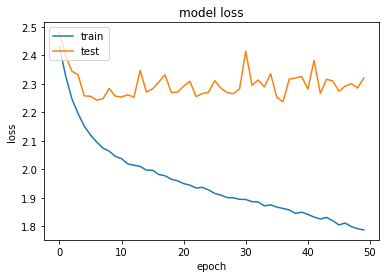

In [16]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

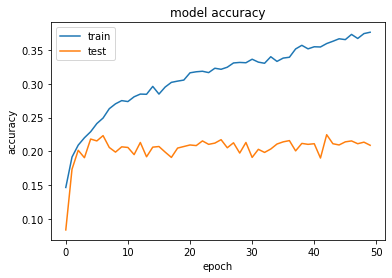

In [17]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It can be observed that the model is definitely overfitting alot, probably to explore other features for further improvement in accuracy

In [18]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\User\Documents\DSI\Capstone\Speech\github\capstone\code\saved_models\Emotion_Model.h5 


In [19]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 20.89%


In [20]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

136/136 [==============================] - 2s 14ms/step


array([ 2,  9,  7, ..., 10, 11,  6], dtype=int64)

In [21]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

Checking prediction results

In [22]:
finaldf = actual.join(preds)
finaldf[150:180]

,actualvalues,predictedvalues
150,female_fear,male_sad
151,female_sad,male_happy
152,male_happy,male_happy
153,male_fear,male_fear
154,female_sad,male_disgust
155,male_neutral,female_disgust
156,female_disgust,female_disgust
157,female_angry,male_angry
158,male_sad,female_neutral
159,male_angry,male_angry


In [23]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,84
female_disgust,163
female_fear,75
female_happy,25
female_neutral,28
female_sad,75
male_angry,212
male_disgust,455
male_fear,183


#### Function call for confution matrix plot

In [24]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.20892774965485503


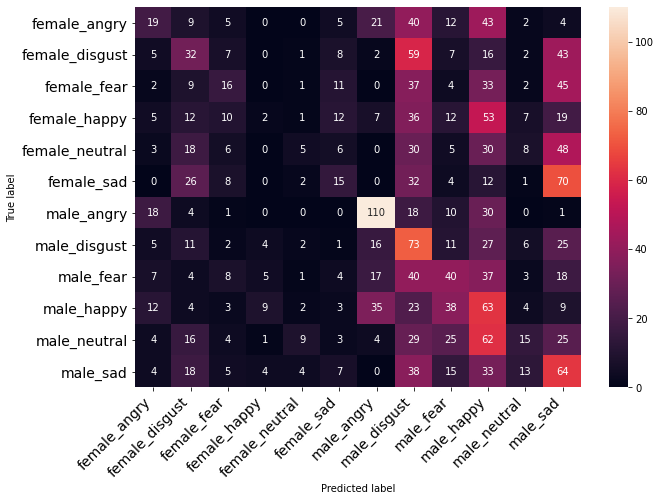

In [25]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [26]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                precision    recall  f1-score   support

  female_angry       0.23      0.12      0.16       160
female_disgust       0.20      0.18      0.19       182
   female_fear       0.21      0.10      0.14       160
  female_happy       0.08      0.01      0.02       176
female_neutral       0.18      0.03      0.05       159
    female_sad       0.20      0.09      0.12       170
    male_angry       0.52      0.57      0.54       192
  male_disgust       0.16      0.40      0.23       183
     male_fear       0.22      0.22      0.22       184
    male_happy       0.14      0.31      0.20       205
  male_neutral       0.24      0.08      0.12       197
      male_sad       0.17      0.31      0.22       205

      accuracy                           0.21      2173
     macro avg       0.21      0.20      0.18      2173
  weighted avg       0.21      0.21      0.19      2173



It is observed that with the CNN model applied as a baseline, the accuracy turns out at 21%

### Gender Classificaton Results

0.5697192820984813


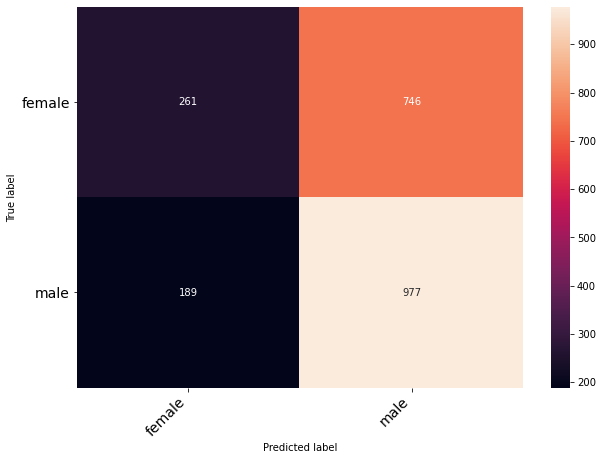

In [27]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [28]:
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.58      0.26      0.36      1007
        male       0.57      0.84      0.68      1166

    accuracy                           0.57      2173
   macro avg       0.57      0.55      0.52      2173
weighted avg       0.57      0.57      0.53      2173



Baseline geneder classification is at 57%

### Emotion Classificaton Results

0.3364012885411873


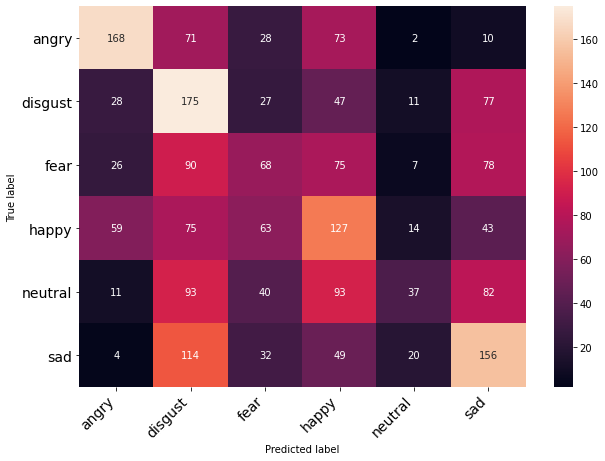

In [29]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [30]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.57      0.48      0.52       352
     disgust       0.28      0.48      0.36       365
        fear       0.26      0.20      0.23       344
       happy       0.27      0.33      0.30       381
     neutral       0.41      0.10      0.17       356
         sad       0.35      0.42      0.38       375

    accuracy                           0.34      2173
   macro avg       0.36      0.33      0.32      2173
weighted avg       0.36      0.34      0.32      2173



Baseline combined gender emotion classification accuracy is at 34%